# **Description**
In this notebook you will firstly train a CNN on cifar10 dataset. The CNN architecture is provided in ``` resnet.py ```. Then you are going to immplement targeted and untargeted FGSM attack and also $l_{∞}$-PGD attack, and evaluate the performance of the trained model on the adversarial data.


**Attention!** Make sure you do not miss the questions asked at the end of the notebook.






Name: Mahdi

Student ID: Shafiee

#**Setups**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#feel free to change the path if needed

cd '/content/drive/MyDrive/DL_HW5'

SyntaxError: ignored

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np

from resnet import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
'''
These are the default values for variables, these should work, but if needed, you are allowed to change these parameters.
'''

batch_size = 128
lr = 1e-3
epochs = 35

#**Data Preparation (5 pts)**
Use cifar10 dataset provided in torchvision and create train and test dataloaders according to the given transformations.

In [4]:
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


###################################################
#prepare training and test datasets and loaders   #
###################################################



######################
# Your code goes here
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170498071/170498071 [00:07<00:00, 22291209.30it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#**Building The Model**

In [5]:
########################################
#build your model                      #
########################################
print('==> Building model..')
net = ResNet18()
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

==> Building model..


#**Training and Evaluating The Model (5 pts)**

In [6]:
# Training
def train(epoch, net, optimizer, trainloader):
    print('\nEpoch: %d' % epoch)
    net.train()
    criterion = nn.CrossEntropyLoss()

    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss/len(trainloader), 100*correct/total


def test(epoch, net, testloader):
    net.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/len(testloader), 100 * correct / total

In [13]:
######################################################################
#train your model, make sure to save loss and accuracy in all epochs #
######################################################################

######################
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
for epoch in range(epochs):
    loss, accuracy = train(epoch, net, optimizer, trainloader)
    train_losses.append(loss)
    train_accuracies.append(accuracy)
    loss, accuracy = test(epoch, net, testloader)
    test_losses.append(loss)
    test_accuracies.append(accuracy)
    print(f'accuracy: {accuracy}')


Epoch: 0
accuracy: 79.39

Epoch: 1
accuracy: 82.4

Epoch: 2
accuracy: 79.5

Epoch: 3
accuracy: 83.51

Epoch: 4
accuracy: 84.04

Epoch: 5
accuracy: 83.56

Epoch: 6
accuracy: 85.56

Epoch: 7
accuracy: 84.86

Epoch: 8
accuracy: 85.07

Epoch: 9
accuracy: 86.39

Epoch: 10
accuracy: 85.7

Epoch: 11
accuracy: 86.2

Epoch: 12
accuracy: 85.04

Epoch: 13
accuracy: 87.1

Epoch: 14
accuracy: 86.81

Epoch: 15
accuracy: 87.35

Epoch: 16
accuracy: 86.98

Epoch: 17
accuracy: 85.22

Epoch: 18
accuracy: 87.52

Epoch: 19
accuracy: 85.29

Epoch: 20
accuracy: 87.39

Epoch: 21
accuracy: 88.56

Epoch: 22
accuracy: 87.66

Epoch: 23
accuracy: 88.31

Epoch: 24
accuracy: 87.67

Epoch: 25
accuracy: 88.3

Epoch: 26
accuracy: 87.7

Epoch: 27
accuracy: 89.0

Epoch: 28
accuracy: 88.49

Epoch: 29
accuracy: 86.72

Epoch: 30
accuracy: 87.78

Epoch: 31
accuracy: 89.21

Epoch: 32
accuracy: 87.47

Epoch: 33
accuracy: 88.79

Epoch: 34
accuracy: 89.23


In [14]:
########################################
#save your model and history           #
########################################


######################
# Your code goes here
from google.colab import drive
drive.mount('/content/drive')
torch.save(net.state_dict(), '/content/drive/My Drive/model.pth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
loaded_net = ResNet18()
loaded_net = net.to(device)
loaded_net.load_state_dict(torch.load('/content/drive/My Drive/model.pth'))
loss, acc = test(epoch, loaded_net, testloader)
print(acc)

89.23


##**Train and Test Loss and Accuracy Plots**

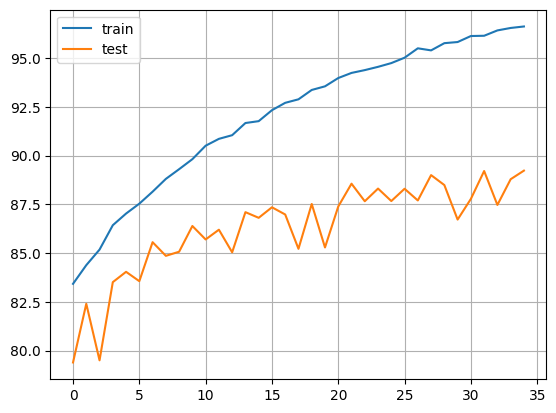

In [19]:
#############################################################
#plot train and test loss and accuracy dusring the training #
#############################################################

######################
# Your code goes here
plt.plot(range(epochs), train_accuracies, label='train')
plt.plot(range(epochs), test_accuracies, label='test')
plt.legend()
plt.grid()
plt.show()

#**FGSM Attack (45 pts)**
In this section you must implement targeted and untargeted FGSM attack and evalute the trained model performance on the adversarial data.[link text](https://)

##**Untargeted FGSM Attack**

In [24]:
########################################
#define untargeted FGSM attack         #
########################################


def FGSM (model, x, y, epsilon):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    epsilon: clipping threshold for FGSM

  outputs:
    x': the perturbed image
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """
  delta = None

  ######################
  # Your code goes here
  x.requires_grad = True
  output = model(x)
  criterion = nn.CrossEntropyLoss()
  loss = criterion(output, y)
  model.zero_grad()
  loss.backward()
  x_grad = x.grad.data
  delta = epsilon * x_grad.sign()

  return x+delta, delta, model(x+delta)

###**Evaluation**


 For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [140]:
  ######################
  # Your code goes here
def test_untargetted_fgsm(model, testloader, epsilon):
    net.eval()

    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        perturbed_input, delat, outputs = FGSM(model, inputs, targets, epsilon)

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return 100 * correct / total

untargeted = []
acc = test_untargetted_fgsm(loaded_net, testloader, 0)
print(f'accuracy for epsilon=0: {acc}')
acc = test_untargetted_fgsm(loaded_net, testloader, 1/255)
untargeted.append(acc)
print(f'accuracy for epsilon=0: {acc}')
acc = test_untargetted_fgsm(loaded_net, testloader, 4/255)
untargeted.append(acc)
print(f'accuracy for epsilon=0: {acc}')
acc = test_untargetted_fgsm(loaded_net, testloader, 8/255)
untargeted.append(acc)
print(f'accuracy for epsilon=0: {acc}')

accuracy for epsilon=0: 89.23
accuracy for epsilon=0: 83.72
accuracy for epsilon=0: 60.71
accuracy for epsilon=0: 34.17


###**FGSM by gradually increasing $ϵ$**

FGSM attack may not work for small $\epsilon$, on the other hand we want to alter image as insignificant as possible, so here is what we do, we start from $\epsilon = \frac{1}{255}$ and if the attack was unsuccessful, we increase $\epsilon$ by $\frac{1}{255}$. The procedure goes on until the predicted label is different from the ground truth.

In [79]:
#######################################################
#increase epsilon gradually till the label is changed. The function can be implemented recursively.#
#######################################################

def generate_adversarial_FGSM (model, x, label, initial_epsilon=1/255):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    epsilon: intial clipping threshold for FGSM

  outputs:
    epsilon: the epsilon that flips the label.
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """



  ######################
  # Your code goes here
  epsilon = initial_epsilon
  x, labels = x.to(device), label.to(device)
  perturbed_input, delat, outputs = FGSM(model, x.view(1, 3, 32, 32), labels.view(1), epsilon)
  while outputs.argmax(1).item() == labels.item():
    epsilon = epsilon + 1/255
    perturbed_input, delat, outputs = FGSM(model, x.view(1, 3, 32, 32), labels.view(1), epsilon)
  return perturbed_input, delat, outputs

### **Visualization**
Pick 10 samples from cifar10 test set, each from one class, make sure the selected samples are classified correctly. Plot these samples. Take note that the selected data must not be transformed by train or test transformations while visualisation.

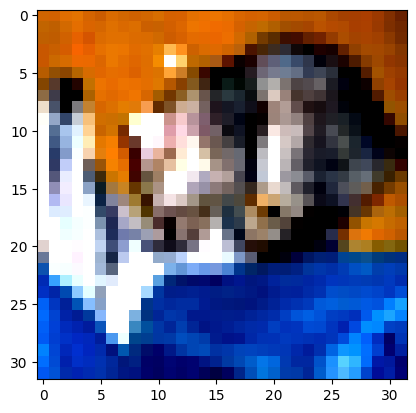

cat


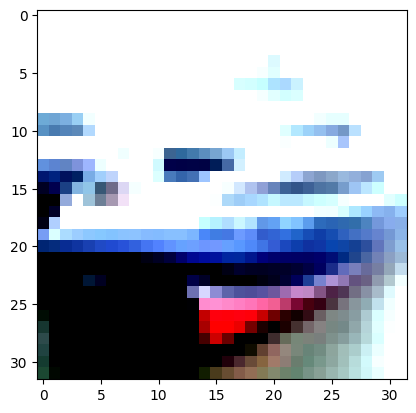

ship


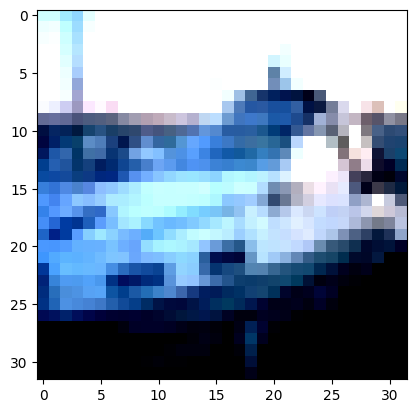

ship


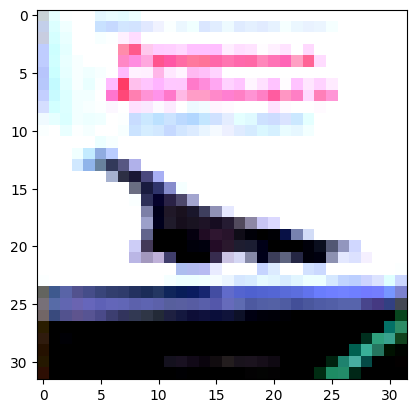

plane


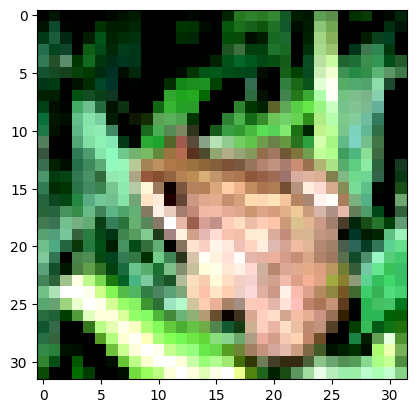

frog


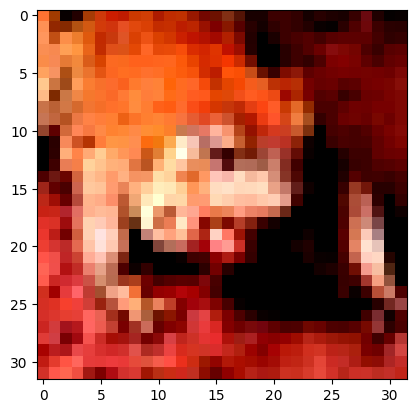

frog


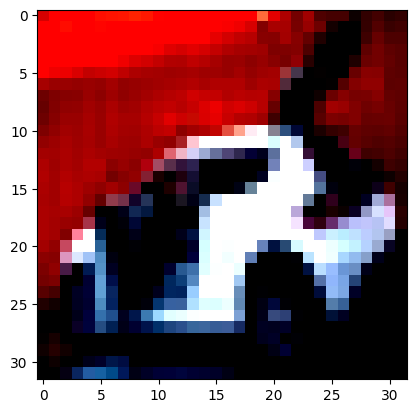

car


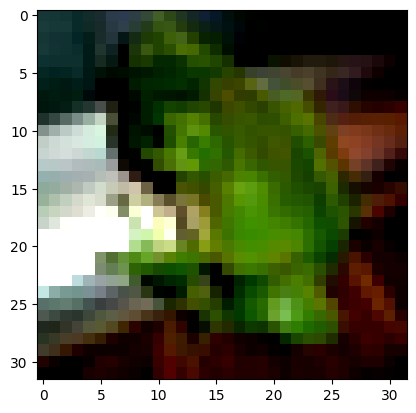

frog


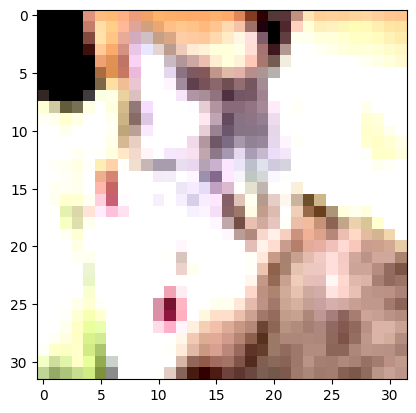

cat


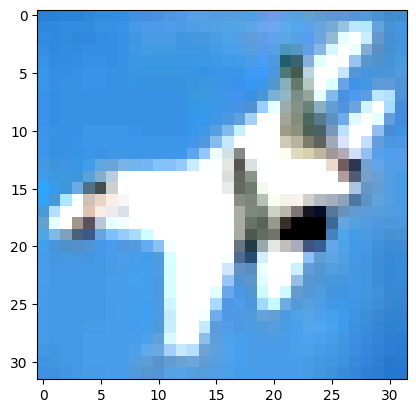

plane


In [62]:
#############################################################################################
#visualize one test sample from each class and make sure that they are correctly labeled.   #
#save index of these samples, since they are needed in the following sections.              #
#############################################################################################

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()





#######################
# Your code goes here

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def get_images():
    saved_classes = []
    images = []
    selected_targets = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        for i in range(len(inputs)):
            input = inputs[i]
            target = targets[i]
            if target.item() == loaded_net(input.view(1, 3, 32, 32)).argmax(1).item() and target.item() not in classes:
                saved_classes.append(target.item())
                imshow(input.cpu())
                images.append(input)
                selected_targets.append(target)
                print(classes[target.item()])
                if len(saved_classes) == 10:
                    return images, targets


selected_images, selected_targets = get_images()


Now, apply untargetted FGSM attack ``` generate_adversarial_FGSM ``` on the selected samples. Visualize the original image, the perturbed image, and the perturbation. since the perturbation is imperceptible, magnify it by the value of $\frac{1}{\epsilon}$ before visualization.

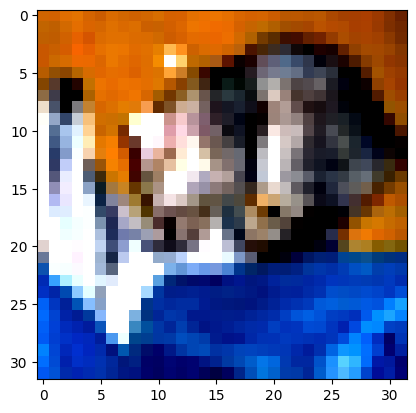

original: cat


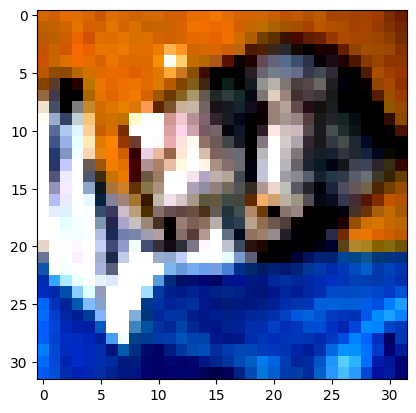

perturbed: dog


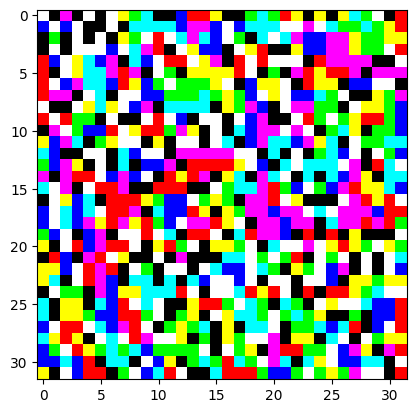

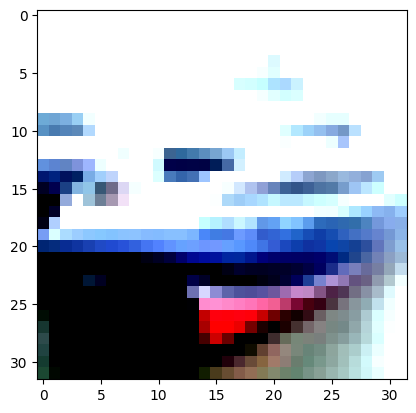

original: ship


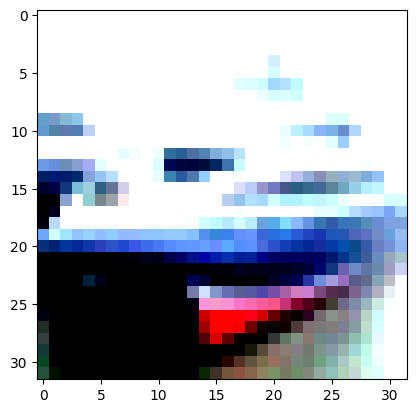

perturbed: car

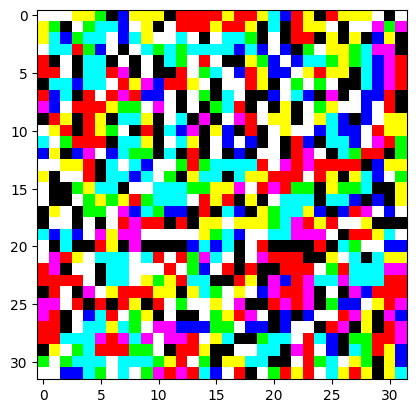

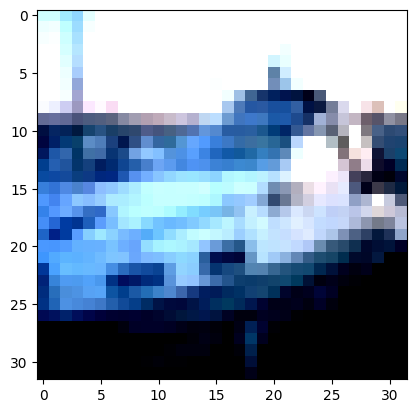

original: ship


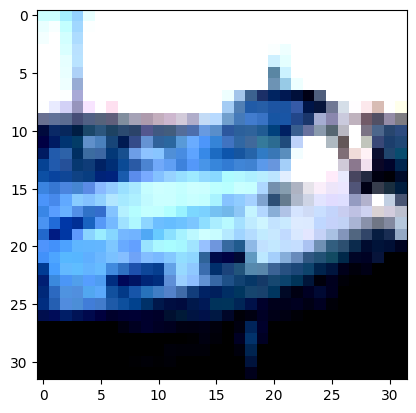

perturbed: car


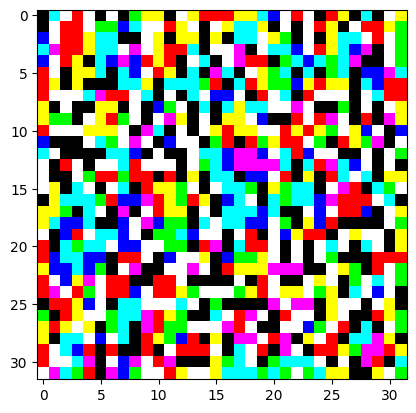

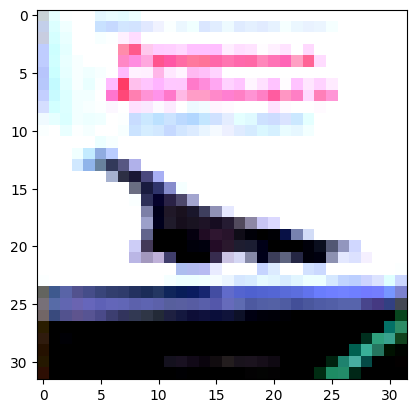

original: plane


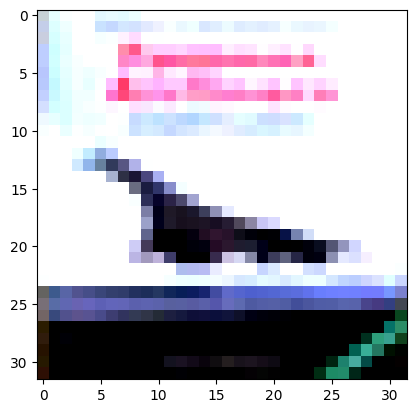

perturbed: ship


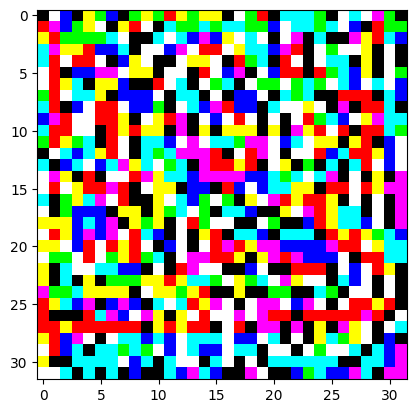

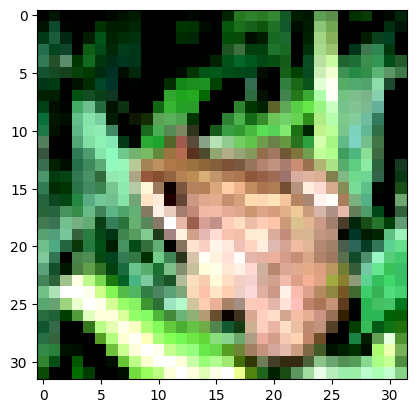

original: frog


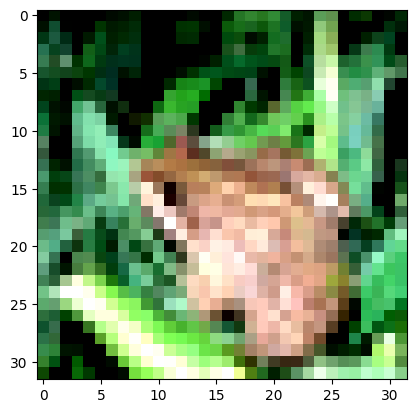

perturbed: bird


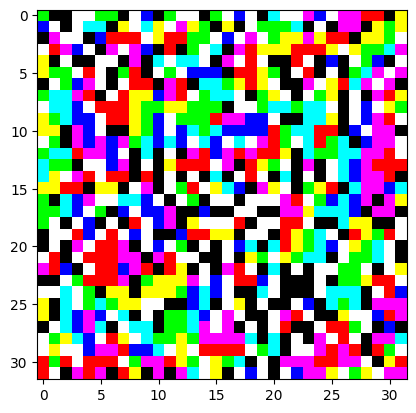

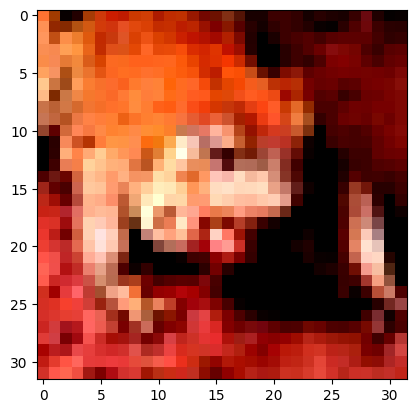

original: frog


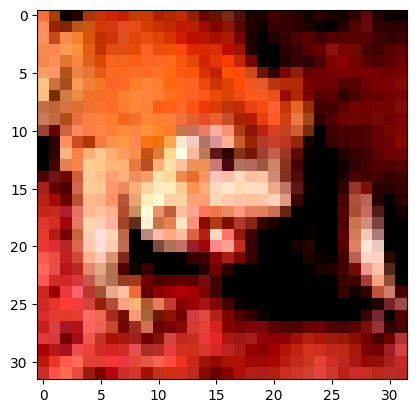

perturbed: cat


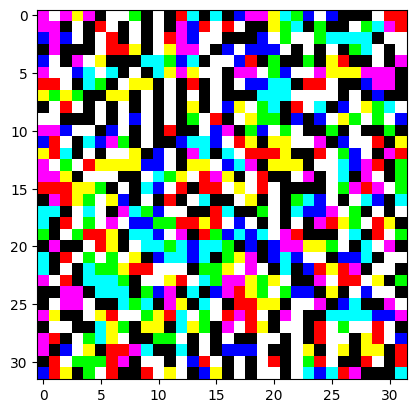

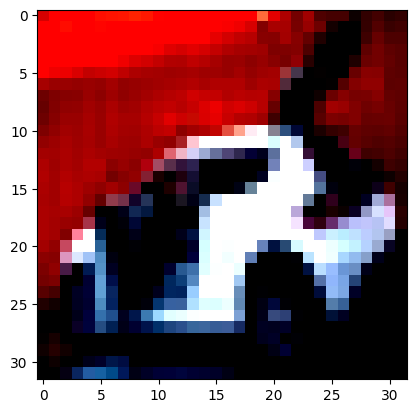

original: car


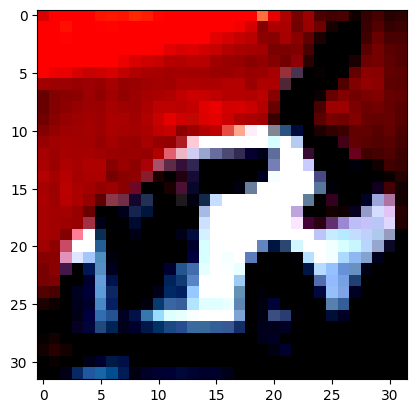

perturbed: cat


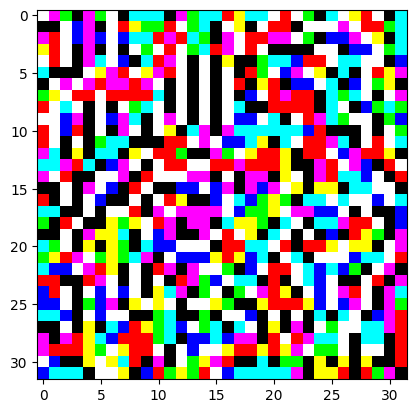

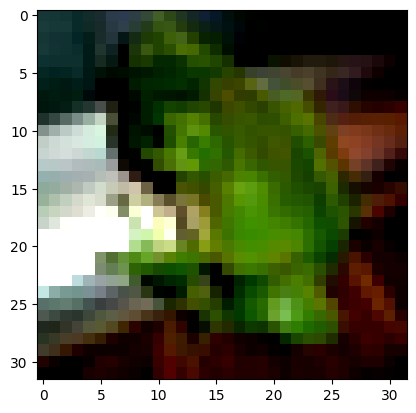

original: frog


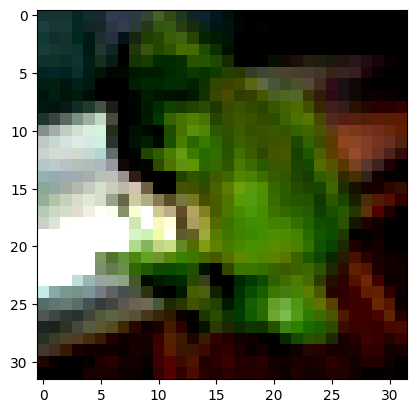

perturbed: cat


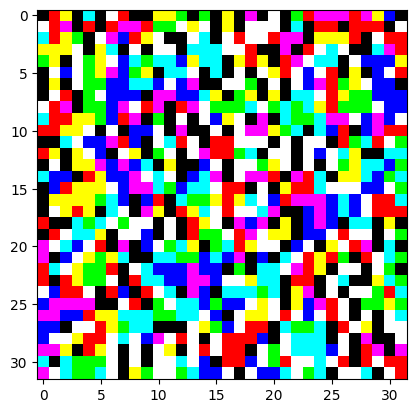

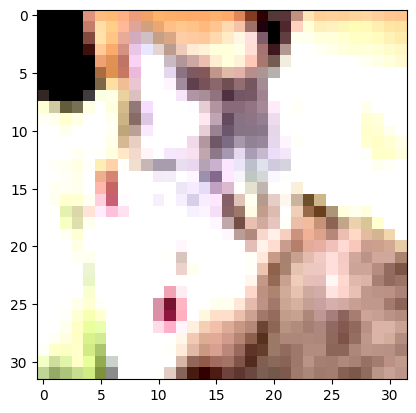

original: cat


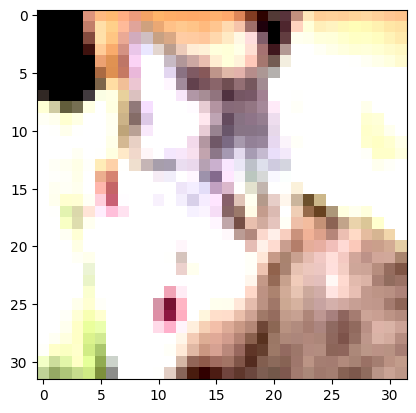

perturbed: deer


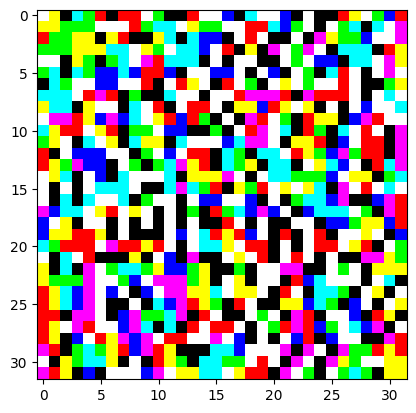

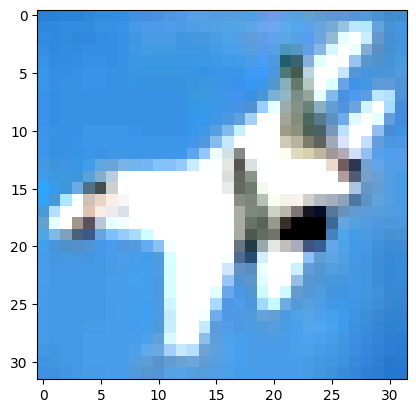

original: car


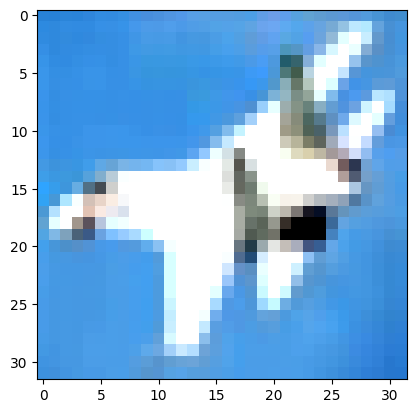

perturbed: plane


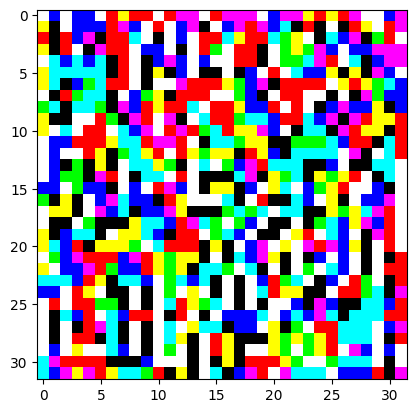

In [102]:
######################################################################################################
#visualize the selected samples, their corresponding perturbed image, and the magnified perturbation #
#also print the ground truth and the predicted label for each sample                                 #
######################################################################################################




######################
# Your code goes here
for i in range(len(selected_images)):
    image = selected_images[i]
    target = selected_targets[i]
    x_prime, delta, output = generate_adversarial_FGSM(loaded_net, image, target)
    imshow(image.cpu())
    print(f'original: {classes[target.item()]}')
    imshow(x_prime.view(3, 32, 32).cpu().detach())
    print(f'perturbed: {classes[output.argmax(1).item()]}')
    imshow(delta.view(3, 32, 32).cpu().detach() * 255)

##**Targeted FGSM Attack**
implement targeted FGSM attack.

In [109]:
########################################
#define tergeted FGSM attack           #
########################################

def FGSM_targeted (model, x, y, y_targ, epsilon):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    y_targ = target label
    epsilon: clipping threshold for FGSM

  outputs:
    x': the perturbed image
    delta: the added perturbation
  """

  delta = None

  ######################
  # Your code goes here

  x.requires_grad = True
  output = model(x)
  criterion = nn.CrossEntropyLoss()
  loss = criterion(output, y_targ)
  model.zero_grad()
  loss.backward()
  x_grad = x.grad.data
  delta = epsilon * x_grad.sign()

  return x-delta, delta, model(x-delta)

###**Evaluation**
for each sample, select the most probable lable as the target label (if the most probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [136]:
######################
# Your code goes here
def test_targetted_fgsm(model, testloader, epsilon):
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        _, y_target = torch.topk(model(inputs), 2, 1)
        perturbed_input, delat, outputs = FGSM_targeted(model, inputs, targets, y_target[:, 1], epsilon)

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return 100 * correct / total

max_targeted = []
max_targeted.append(test_targetted_fgsm(loaded_net, testloader, 1/255))
max_targeted.append(test_targetted_fgsm(loaded_net, testloader, 4/255))
max_targeted.append(test_targetted_fgsm(loaded_net, testloader, 8/255))

for each sample, select the least probable lable as the target label (if the least probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [137]:
######################
# Your code goes here
def test_targetted_fgsm(model, testloader, epsilon):
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        _, y_target = torch.topk(-model(inputs), 2, 1)
        perturbed_input, delat, outputs = FGSM_targeted(model, inputs, targets, y_target[:, 1], epsilon)

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return 100 * correct / total

min_targeted = []
min_targeted.append(test_targetted_fgsm(loaded_net, testloader, 1/255))
min_targeted.append(test_targetted_fgsm(loaded_net, testloader, 4/255))
min_targeted.append(test_targetted_fgsm(loaded_net, testloader, 8/255))

plot accuracy of model with respect to $\epsilon$ both for least probable and most probable target labels (both in a single plot).

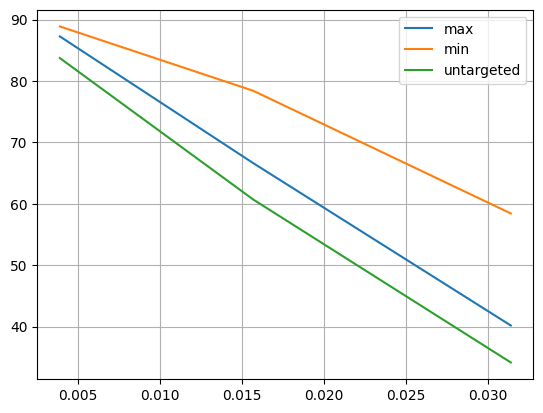

In [141]:
######################
# Your code goes here

epsilons = [1/255, 4/255, 8/255]
plt.plot(epsilons, max_targeted, label='max')
plt.plot(epsilons, min_targeted, label='min')
plt.plot(epsilons, untargeted, label='untargeted')
plt.legend()
plt.grid()
plt.show()

#**PGD Attack (30 pts)**

Implement PGD attack in the following cell. There is no need to change the default $\epsilon$ and $\alpha$.

In [142]:
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()

    ori_images = images.data

    for i in range(iters) :
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    return images

##**Evaluation**
for iterations $\in \{3, 7, 12\}$, evaluate performance of the model on adversarial test data.

In [146]:
######################
# Your code goes here

def test_pgd(model, iteration, testloader):
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        images = pgd_attack(model, inputs, targets, iters=iteration)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return 100 * correct / total

print(f'accurarcy for iterations=3: {test_pgd(loaded_net, 3, testloader)}')
print(f'accurarcy for iterations=7: {test_pgd(loaded_net, 7, testloader)}')
print(f'accurarcy for iterations=12: {test_pgd(loaded_net, 12, testloader)}')

accurarcy for iterations=3: 25.26
accurarcy for iterations=7: 7.11
accurarcy for iterations=12: 2.2


#**Questions (15 pts)**

1. What was the effect of $\epsilon$ in targeted and untargeted FGSM attack according to your observations?

2. Compare performance of the model on the least probable and most probable targetted FGSM attacks, justify your observation.

3. What was the effect of number of iterations in PGD attack according to your observations?

4. compare the performance of model on PGD attacks and FGSM attacks.

1. By increasing ϵ, accuracy decreases in both targeted and untargeted FGSM, but accurcay decreases more in untargeted approach.<br>
2. Accurcay of the model decreases more in the most probable targeted FGSM, because by moving towrards the class which from the model's point of view is close to the right answer but it is still wrong, we make the task of distinguishing between these two classes harder for our model, thus the model fails to give correct answer for these images very quickly. But in the least probable case, even if we move towrards the least probable class, the model can distinguish more easily and can give better answers. <br>
3. Accuracy of the model decreases substantially by increasing number of iterations.
4. As we can see in the previous section, after just 12 iterations, accuracy of model drops to 2.2 percent, thus we can deduce that PGD is much more effective than FGSM.